# Acknowledgements

In [1]:
# Original code and project idea from Lu Lu et al.
# https://github.com/lululxvi/deepxde/tree/master

# Imports

In [9]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

# Custom Functions and Equation Setup

In [3]:
def pde(x, y):
    """
    Defines the discretized solution to the 1D Burgers' Equation.

    IC u(x, 0) = - sin(\pi x), u( - 1, t) = u(1, t) = 0.
    """
    dy_x = dde.grad.jacobian(y, x, i=0, j=0) # solves first partial w.r.t x
    dy_t = dde.grad.jacobian(y, x, i=0, j=1) # solves first partial w.r.t y
    dy_xx = dde.grad.hessian(y, x, i=0, j=0) # solves second partial deritive
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [4]:
# modeling constraints to imitate the Burgers' equations' limitations in physical context
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=100, num_initial=100)

In [5]:
# sets up model for training
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Exact Solution / Model Data

In [6]:
def gen_testdata():
    """ 
    Extracts the exact solution for the Burgers' equation.
    """
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

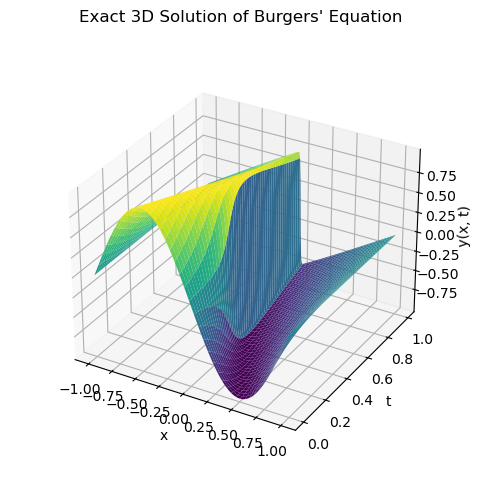

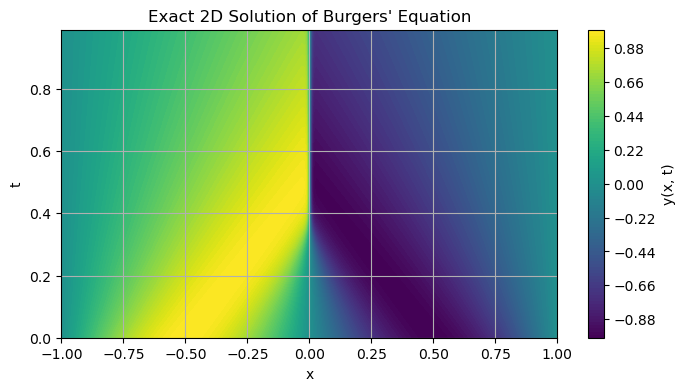

In [52]:
# Generate test data
X, y = gen_testdata()

# Reshape data for plotting
xx = X[:, 0].reshape(len(np.unique(X[:, 1])), -1)
tt = X[:, 1].reshape(len(np.unique(X[:, 1])), -1)
yy = y.reshape(xx.shape)

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, tt, yy, cmap='viridis')
plt.title("Exact 3D Solution of Burgers' Equation")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("y(x, t)")
ax.set_box_aspect(None, zoom=0.85)
filename = "Burgers-3D"
plt.savefig(f"../images/{filename}.png")
plt.show()

# 2D Plot
plt.figure(figsize=(8, 4))
contour = plt.contourf(xx, tt, yy, cmap='viridis', levels=100)
plt.colorbar(contour, label="y(x, t)")
plt.title("Exact 2D Solution of Burgers' Equation")
plt.xlabel("x")
plt.ylabel("t")
plt.grid(True)
filename = "Burgers-2D"
plt.savefig(f"../images/{filename}.png")
plt.show()

# Training and Visualizing Model Performance

In [7]:
# initial two-step model training
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

X = geomtime.random_points(100000)
err = 1
while err > 0.005: # RAR process
    # calculate the residuals and mean residual error
    f = model.predict(X, operator=pde) # pde is being incorporated in the prediction here, making it a PINNs
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    # find the point with the highest error and add to anchors
    x_id = np.argmax(err_eq) 
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])

    # early stopping condition
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)

    # update the model
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000257 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.12e-01, 1.06e-01, 7.60e-01]    [3.12e-01, 1.06e-01, 7.60e-01]    []  
1000      [4.27e-02, 9.57e-04, 5.77e-02]    [4.27e-02, 9.57e-04, 5.77e-02]    []  
2000      [3.42e-02, 8.87e-05, 4.84e-02]    [3.42e-02, 8.87e-05, 4.84e-02]    []  
3000      [1.92e-02, 8.86e-05, 2.72e-02]    [1.92e-02, 8.86e-05, 2.72e-02]    []  
4000      [6.91e-03, 2.96e-05, 5.72e-03]    [6.91e-03, 2.96e-05, 5.72e-03]    []  
5000      [3.80e-03, 1.53e-05, 3.52e-03]    [3.80e-03, 1.53e-05, 3.52e-03]    []  
6000      [2.45e-03, 6.48e-06, 2.46e-03]    [2.45e-03, 6.48e-06, 2.46e-03]    []  
7000      [1.75e-03, 3.46e-06, 1.73e-03]    [1.75e-03, 3.46e-06, 1.73e-03]    []  
8000      [1.34e-03, 2.31e-06, 1.19e-03]    [1.34e-03, 2.31e-06, 1.19e-03]    []  
9000      [1.10e-03, 1.95e-06, 9.44e-04]    [1.10e-03, 1.95e-06, 9.44e-04]    []  
10000     [9.47

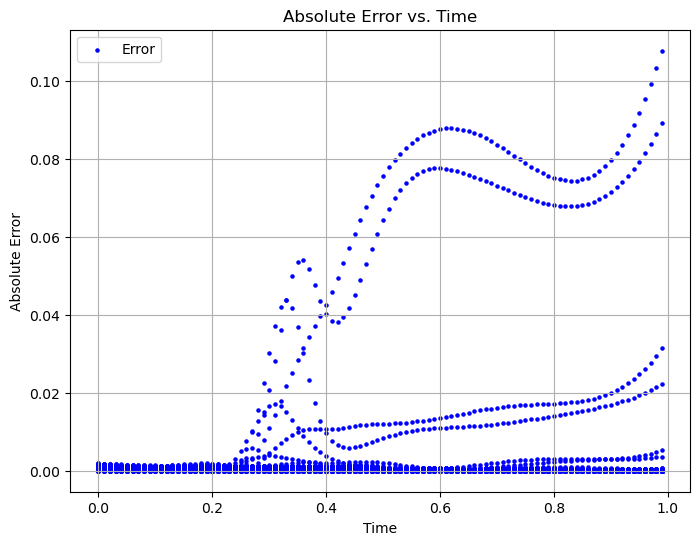

In [43]:
# Generate test data
X_test, y_test = gen_testdata()
y_pred = model.predict(X_test)
error = np.abs(y_test - y_pred) # compute the error

# Plot the error
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 1], error, s=5, c='b', label='Error')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.title('Absolute Error vs. Time')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Generate training data
def gen_train_data(n_samples):
    geom = dde.geometry.Interval(-1, 1)
    timedomain = dde.geometry.TimeDomain(0, 0.99)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    data = dde.data.TimePDE(geomtime, pde, ic, bc, num_domain=n_samples)
    return data

# Define the neural network architecture
def neural_net():
    return dde.models.MLP([2] + [20] * 3 + [1], activation='tanh')

# Train the model
def train_model():
    data = gen_train_data(100)
    model = dde.Model(data, neural_net())
    model.compile('adam', lr=0.001)
    losshistory, train_state = model.train(epochs=10000)
    return model

# Plot the solution
def plot_solution(model):
    x = np.linspace(-1, 1, 100)
    t = np.linspace(0, 0.99, 100)
    X, T = np.meshgrid(x, t)
    X_flat = np.vstack((np.ravel(X), np.ravel(T))).T
    u_pred = model.predict(X_flat)
    U = u_pred.reshape(X.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(T, X, U, cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title("Approximate Solution to Burgers' Equation")
    plt.show()


model = train_model()
plot_solution(model)

TypeError: TimePDE.__init__() got multiple values for argument 'num_domain'

Saving loss history to d:\GitHub\pinns-teaching-uis\burgers-example\loss.dat ...
Saving training data to d:\GitHub\pinns-teaching-uis\burgers-example\train.dat ...
Saving test data to d:\GitHub\pinns-teaching-uis\burgers-example\test.dat ...


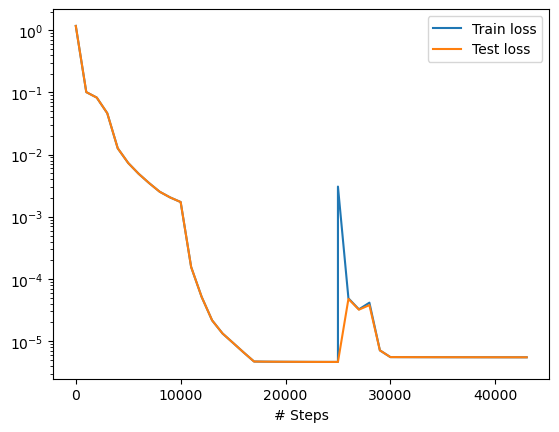

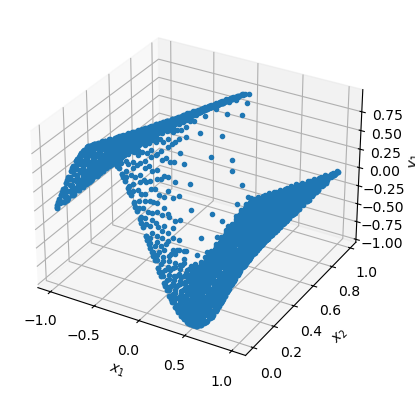

In [39]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [40]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

L2 relative error: 0.008810617074616486
